In [92]:
%%capture --no-stderr
%pip install -U langgraph ollama unidiff langchain-ollama langchain-core

In [57]:
import os
import sys
from pathlib import Path
from langchain_core.tools import tool

from typing import Annotated, Sequence, List, Optional, Literal, Any, Dict
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
import os
from unidiff import PatchSet, PatchedFile
from io import StringIO
import json
from rich.console import Console
from rich.panel import Panel
from rich.syntax import Syntax
from langchain_core.runnables.graph import MermaidDrawMethod  # Neuer Import
from pathlib import Path
from langchain_core.prompts import PromptTemplate

In [87]:
class GitFileChange(BaseModel):
    """Detailed analysis of a single file change"""
    path: str
    change_type: Literal["NEW", "DELETED", "RENAMED", "MODE_CHANGED", "MODIFIED", "BINARY", "SUBMODULE", "CONFLICT"]
    old_path: Optional[str] = None
    added_lines: int = 0
    removed_lines: int = 0
    hunks: List[dict] = Field(default_factory=list)
    purpose: str = Field(description="Description of what changed and why")

class GitDiffAnalysis(BaseModel):
    """Structured Analysis of Git Changes"""
    summary: str = Field(description="Brief technical summary of all changes")
    change_type: Literal["feat", "fix", "docs", "refactor", "test", "chore", "style", "perf"]
    files: List[GitFileChange]
    breaking_change: bool = Field(default=False)

class ConventionalCommit(BaseModel):
    """Structured Conventional Commit Message"""
    type: Literal["feat", "fix", "docs", "refactor", "test", "chore", "style", "perf"]
    scope: Optional[str] = None
    description: str = Field(description="Imperative description of the change")
    breaking: bool = False
    body: Optional[str] = None
    footer: Optional[str] = None

class CommitQuality(BaseModel):
    """Binary Quality Check Result"""
    is_valid: bool

In [127]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState


## Agent State      
class AgentState(TypedDict):
#class AgentState(MessagesState):
    """Speichert den aktuellen Zustand des Agenten"""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    #messages: Annotated[list, add_messages]
    #final_response: GitFileChange

    
graph_builder = StateGraph(AgentState)

In [89]:
from langchain_ollama import ChatOllama
agent_llm = ChatOllama(
    model="granite3-dense:8b",
    temperature=0,
    # other params...
)
#.bind_tools([parse_git_diff])

In [128]:
from langchain_core.tools import tool

#@tool
def parse_git_diff(diff_text: str) -> List[GitFileChange]:
    """
    Parses Git-Diffs into a List of GitFileChange structure
    """
    patch_set = PatchSet(StringIO(diff_text))
    changes: List[GitFileChange] = []
    
    print(f"Found {len(patch_set)} files in diff")
    
    for patched_file in patch_set:
        # Basis-Informationen
        path = patched_file.path.lstrip('b/')  # Entferne 'b/' Prefix
        
        # Change Type Detection
        if patched_file.is_added_file:  # Neue Datei
            change_type = "NEW"
            old_path = None
            print(f"NEW file: {path}")
        elif patched_file.is_removed_file:  # Gelöschte Datei
            change_type = "DELETED"
            old_path = patched_file.source_file.lstrip('a/')
            print(f"DELETED file: {path}")
        elif patched_file.is_rename:  # Umbenannte Datei
            change_type = "RENAMED"
            old_path = patched_file.source_file.lstrip('a/')
            print(f"RENAMED file from {old_path} to {path}")
        elif patched_file.is_binary_file:  # Binärdatei
            change_type = "BINARY"
            old_path = None
            print(f"BINARY file: {path}")
        else:  # Normale Änderung
            change_type = "MODIFIED"
            old_path = None
            print(f"MODIFIED file: {path}")
            
        # Hunk Analysis
        hunks = []
        total_added = 0
        total_removed = 0
        
        for hunk in patched_file:
            added = len([l for l in hunk if l.is_added])
            removed = len([l for l in hunk if l.is_removed])
            total_added += added
            total_removed += removed
            
            hunk_info = {
                "old_start": hunk.source_start,
                "old_length": hunk.source_length,
                "new_start": hunk.target_start,
                "new_length": hunk.target_length,
                "added_lines": added,
                "removed_lines": removed,
                "modified_lines": len(hunk)
            }
            hunks.append(hunk_info)
            
        print(f"  Lines: +{total_added} -{total_removed}")
            
        # Erstelle direkt ein GitFileChange-Objekt
        change = GitFileChange(
            path=path,
            change_type=change_type,
            old_path=old_path,
            added_lines=total_added,
            removed_lines=total_removed,
            hunks=hunks,
            purpose=""  # Soll von LLM gefüllt werden
        )
        changes.append(change)  # Füge das Objekt direkt hinzu
    
    return changes

In [129]:
# second node with ollama python
# Node: retrieve_parsed_diff where everything is started
from ollama import chat
from ollama import ChatResponse

# @tool
def retrieve_parsed_diff(state: AgentState):
    messages = state["messages"]
    diff_text = messages[0].content

    response = chat(
        model="llama3.2",
        messages=[{"role": "user", "content": diff_text}],
        # format_schema=GitFileChange.model_json_schema(),
        options={"temperature": 0},
        tools=[parse_git_diff],
    )

    # response_typed = GitDiffAnalysis.model_validate_json(response.message.content)
    available_functions = {
        "parse_git_diff": parse_git_diff
    }
    for tool in response.message.tool_calls or []:
      function_to_call = available_functions.get(tool.function.name)
      print("function_to_call", function_to_call)
      if function_to_call:
        final_response = function_to_call(**tool.function.arguments)
        print("final_response", final_response)
      else:
        print('Function not found:', tool.function.name)

    return {"messages": [final_response]}
    # return {"messages": [agent_llm.invoke(state["messages"])]}

In [130]:
graph_builder.add_node("get_diff", retrieve_parsed_diff)

In [91]:
tools = [parse_git_diff, GitFileChange, GitDiffAnalysis]
agent_llm = agent_llm.bind_tools(tools)

In [131]:
# Node: retrieve_parsed_diff where everything is started
def retrieve_parsed_diff(state: AgentState):
    messages = state["messages"]
    diff_text = messages[0].content
        
    #llm_with_tool = agent_llm.with_structured_output(GitDiffAnalysis)
    prompt = PromptTemplate(
        template="""
        You are a git diff parser. You are given a git diff and you need to provide a detailed JSON output with detailes included.\n\n
        Here is the git diff: {diff_text}\n\n
        
        I want a very detailed analysis with:
        1. Technical Analysis
        - Number and types of files changed
        - Lines added/removed per file
        - Location of changes in the codebase
        - Pattern of modifications (hunks distribution) \n\n

        2. Change Classification
        - Determine the primary change type (feat/fix/docs/etc.)
        - Identify if changes are breaking or non-breaking
        - Assess the scope of the changes \n\n

        3. Purpose Assessment
        For each modified file:
        - Technical purpose of the changes
        - Impact on the codebase
        - Relationship to other changed files
        - Context within the broader system\n\n

        4. Summary
        - Brief technical overview
        - Key impacts and implications
        - Related components affected\n\n

        
        Please provide a structured analysis based on the Git diff data as JSON.
        Please use available tools to get the information you need.
        
        """,
        input_variables=["diff_text"]
    )
    chain = prompt | agent_llm
    
    response = chain.invoke({"diff_text": diff_text})
    return {"messages": [response]}
    #return {"messages": [agent_llm.invoke(state["messages"])]}
    
graph_builder.add_node("get_diff", retrieve_parsed_diff)

ValueError: Node `get_diff` already present.

In [132]:
graph_builder.add_edge(START, "get_diff")
graph_builder.add_edge("get_diff", END)


In [133]:
graph = graph_builder.compile()


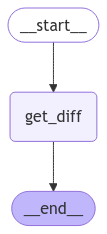

In [125]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [135]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()

diff = """ Following git-diff, make a structured analysis of the changes: \n
    diff --git a/old-name.ts b/new-name.ts
    similarity index 100%
    rename from old-name.ts
    rename to new-name.ts
"""
#diff = query
inputs = {"messages": [("user", diff)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

 Following git-diff, make a structured analysis of the changes: 

    diff --git a/old-name.ts b/new-name.ts
    similarity index 100%
    rename from old-name.ts
    rename to new-name.ts

function_to_call <function parse_git_diff at 0x11d779e40>
Found 1 files in diff
RENAMED file from old-name.ts to new-name.ts
  Lines: +0 -0
final_response [GitFileChange(path='new-name.ts', change_type='RENAMED', old_path='old-name.ts', added_lines=0, removed_lines=0, hunks=[], purpose='')]


NotImplementedError: Unsupported message type: <class 'list'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 

# ReACT Agent

In [55]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import Sequence, Annotated, Optional

# 1. Zustandsklasse
class AgentState(MessagesState):
    """Speichert den aktuellen Zustand des Agenten"""
    final_response: Optional[GitFileChange] = None
    messages: Annotated[Sequence[BaseMessage], add_messages]

# 2. Model und Tools Setup
tools = [parse_git_diff]
model_with_tools = agent_llm.bind_tools(tools)
model_with_structured_output = agent_llm.with_structured_output(GitFileChange)

# 3. Nodes
def call_model(state: AgentState):
    """Ruft das Modell auf"""
    response = model_with_tools.invoke(state["messages"])
    return {"messages": [response]}

def respond(state: AgentState):
    """Erstellt strukturierte Antwort"""
    messages = state["messages"]
    
    # Finde das Tool-Ergebnis
    tool_result = None
    for msg in reversed(messages):
        if hasattr(msg, 'content') and isinstance(msg.content, str):
            tool_result = msg.content
            break
    
    if not tool_result:
        raise ValueError("Kein Tool-Ergebnis gefunden")
        
    response = model_with_structured_output.invoke([
        HumanMessage(content=f"""Analyze this git diff and create a GitFileChange:
        - Determine the file path
        - Identify the change type (NEW/MODIFIED/etc.)
        - Count added and removed lines
        - Describe the purpose of the change

        Git diff:
        {tool_result}
        """)
    ])
    return {"final_response": response}

# 4. Graph Setup
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)

workflow.set_entry_point("agent")

# 5. Routing
def should_continue(state: AgentState):
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "respond"
    return "continue"

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    }
)
workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)

# Graph kompilieren
graph = workflow.compile()

# 6. Helper für die Ausgabe
def print_file_change(change: GitFileChange):
    """Zeigt die GitFileChange-Informationen an"""
    print("\n=== Git File Change ===")
    print(f"Datei: {change.path}")
    print(f"Änderungstyp: {change.change_type}")
    if change.old_path:
        print(f"Alter Pfad: {change.old_path}")
    print(f"Zeilen: +{change.added_lines} -{change.removed_lines}")
    print(f"Zweck: {change.purpose}")
    if change.hunks:
        print(f"Anzahl Hunks: {len(change.hunks)}")

# 7. Verwendung
def analyze_git_change(diff_content: str):
    """Analysiert eine einzelne Dateiänderung"""
    inputs = {
        "messages": [HumanMessage(content=diff_content)]
    }
    
    for output in graph.stream(inputs, stream_mode="values"):
        if "final_response" in output and output["final_response"]:
            print_file_change(output["final_response"])
        elif "messages" in output:
            for msg in output["messages"]:
                if hasattr(msg, "content"):
                    print(f"\n{msg.type}: {msg.content}")


In [56]:
test_diff = """
    diff --git a/script.sh b/script.sh
    index 1234567..89abcde 100644
    --- a/script.sh
    +++ b/script.sh
    @@ -1,3 +1,7 @@
    +fi
    +
    +# Check if there are any staged changes
    +diff=$(git diff --cached | cat)
    +if [ -z "$diff" ]; then
    +  echo "No staged changes to commit."
    +  exit 1
    """
    
analyze_git_change(test_diff)


human: 
    diff --git a/script.sh b/script.sh
    index 1234567..89abcde 100644
    --- a/script.sh
    +++ b/script.sh
    @@ -1,3 +1,7 @@
    +fi
    +
    +# Check if there are any staged changes
    +diff=$(git diff --cached | cat)
    +if [ -z "$diff" ]; then
    +  echo "No staged changes to commit."
    +  exit 1
    

human: 
    diff --git a/script.sh b/script.sh
    index 1234567..89abcde 100644
    --- a/script.sh
    +++ b/script.sh
    @@ -1,3 +1,7 @@
    +fi
    +
    +# Check if there are any staged changes
    +diff=$(git diff --cached | cat)
    +if [ -z "$diff" ]; then
    +  echo "No staged changes to commit."
    +  exit 1
    

ai: Based on the provided Git diff, here's a breakdown of the changes:

1. Two new lines have been added at the beginning of the script. These lines are `fi` and a comment `# Check if there are any staged changes`.
2. A new block of code has been added after the existing code. This block checks if there are any staged changes using the `gi

In [14]:
# Knoten definieren
from langgraph.prebuilt import ToolNode
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools = [parse_git_diff, GitFileChange]
agent_llm = agent_llm.bind_tools(tools)

def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = agent_llm.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)

# Entrypoint setzen
workflow.set_entry_point("agent")

# Bedingte Kanten hinzufügen
def should_continue(state: AgentState):
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "respond"
    return "continue"

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    }
)

# Normale Kanten
workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)

# Graph kompilieren
graph = workflow.compile()

In [15]:
# Helper function für die Ausgabe
def print_stream(stream):
    for s in stream:
        if "final_response" in s:
            print("Finale strukturierte Antwort:")
            print(s["final_response"])
        elif "messages" in s:
            for msg in s["messages"]:
                if hasattr(msg, "content"):
                    print(f"{msg.type}: {msg.content}")

# Test-Diff
diff = """Parse the following git-diff: \n
    diff --git a/old-name.ts b/new-name.ts
    similarity index 100%
    rename from old-name.ts
    rename to new-name.ts
"""

# Eingabe vorbereiten
inputs = {
    "messages": [HumanMessage(content=diff)]
}

# Graph ausführen und Ergebnisse ausgeben
print_stream(graph.stream(inputs, stream_mode="values"))

human: Parse the following git-diff: 

    diff --git a/old-name.ts b/new-name.ts
    similarity index 100%
    rename from old-name.ts
    rename to new-name.ts

human: Parse the following git-diff: 

    diff --git a/old-name.ts b/new-name.ts
    similarity index 100%
    rename from old-name.ts
    rename to new-name.ts

ai: Based on the provided Git-Diff, here is the parsed information:

```json
{
  "change_type": "rename",
  "purpose": "The file was renamed from 'old-name.ts' to 'new-name.ts'",
  "hunks": [],
  "added_lines": 0,
  "removed_lines": 0,
  "path": "new-name.ts"
}
```
Finale strukturierte Antwort:
None


In [40]:
query = """\n\n
    diff --git a/git-ai-commit.sh b/git-ai-commit.sh
new file mode 100755
index 0000000000..d7cf9c8873
--- /dev/null
+++ b/git-ai-commit.sh
@@ -0,0 +1,57 @@
+#!/bin/bash
+
+# Check if files are passed as arguments or if the user wants to add all changes
+if [ "$#" -eq 0 ]; then
+  echo "No files specified. Staging all changes..."
+  git add .
+else
+  echo "Staging specified files..."
+  git add "$@"
+fi
+
+# Check if there are any staged changes
+diff=$(git diff --cached | cat)
+if [ -z "$diff" ]; then
+  echo "No staged changes to commit."
+  exit 1
+fi
+
+# Escape the diff for JSON compatibility
+escaped_diff=$(echo "$diff" | jq -Rsa .)
+
+# Prepare the payload for Ollama
+data=$(jq -n --arg diff "$escaped_diff" '{
+  "model": "llama3.2",
+  "stream": false,
+  "prompt": ("" + $diff)
+}')
+
+# Call the Ollama API to generate the commit message
+response=$(curl -s -X POST http://localhost:11434/api/generate -d "$data" -H "Content-Type: application/json")
+
+# Extract the commit message from the API response
+commit_message=$(echo "$response" | jq -r '.response')
+
+# Check if a commit message was generated
+if [ -z "$commit_message" ]; then
+  echo "Error: Failed to generate a commit message."
+  exit 1
+fi
+
+# Display the generated commit message in the console
+echo "AI-Generated Commit Message:"
+echo "--------------------------------------"
+echo "$commit_message"
+echo "--------------------------------------"
+
+# Confirm with the user before committing
+read -p "Do you want to use this commit message? (y/n): " confirm
+if [[ "$confirm" != "y" ]]; then
+  echo "Commit aborted."
+  exit 1
+fi
+
+# Use the generated commit message directly in the commit
+git commit -m "$commit_message"
+
+echo "Commit created successfully with AI-generated message!"
\ No newline at end of file
diff --git a/packages/react/docs/ai-optimization.md b/packages/react/docs/ai-optimization.md
new file mode 100644
index 0000000000..fc725e8385
--- /dev/null
+++ b/packages/react/docs/ai-optimization.md
@@ -0,0 +1,16 @@
+
+# AI-Powered Code Optimization
+
+This module provides real-time code analysis and optimization suggestions using AI.
+
+## Features
+- Real-time code analysis
+- Performance metrics collection
+- AI-powered suggestions
+- Pattern detection
+
+## Architecture
+- AICodeOptimizer: Core orchestration
+- CodeAnalyzer: Static analysis
+- MetricsCollector: Runtime metrics
+
diff --git a/packages/react/src/ai/optimizer.ts b/packages/react/src/ai/optimizer.ts
new file mode 100644
index 0000000000..0e1fcd4606
--- /dev/null
+++ b/packages/react/src/ai/optimizer.ts
@@ -0,0 +1,18 @@
+
+import { OpenAI } from "./ai/openai";
+import { CodeAnalyzer } from "./analysis/code";
+import { MetricsCollector } from "./metrics/collector";
+
+export class AICodeOptimizer {
+  constructor() {
+    this.ai = new OpenAI();
+    this.analyzer = new CodeAnalyzer();
+    this.metrics = new MetricsCollector();
+  }
+
+  async analyze(code: string) {
+    const metrics = await this.metrics.collect(code);
+    const analysis = await this.analyzer.analyze(code);
+    return this.ai.suggest(metrics, analysis);
+  }
+}
diff --git a/packages/react/src/analysis/code.ts b/packages/react/src/analysis/code.ts
new file mode 100644
index 0000000000..66ae5494fd
--- /dev/null
+++ b/packages/react/src/analysis/code.ts
@@ -0,0 +1,10 @@
+
+export class CodeAnalyzer {
+  analyze(code: string) {
+    return {
+      complexity: this.calculateComplexity(code),
+      patterns: this.detectPatterns(code),
+      issues: this.findIssues(code)
+    };
+  }
+}
diff --git a/packages/react/src/components/CodeOptimizationPanel.tsx b/packages/react/src/components/CodeOptimizationPanel.tsx
new file mode 100644
index 0000000000..cacb561952
--- /dev/null
+++ b/packages/react/src/components/CodeOptimizationPanel.tsx
@@ -0,0 +1,22 @@
+
+import { AICodeOptimizer } from "../ai/optimizer";
+import { useEffect, useState } from "react";
+
+export const CodeOptimizationPanel = () => {
+  const [optimizer] = useState(() => new AICodeOptimizer());
+  const [suggestions, setSuggestions] = useState([]);
+
+  useEffect(() => {
+    optimizer.analyze(currentCode)
+      .then(setSuggestions);
+  }, [currentCode]);
+
+  return (
+    <div className="optimization-panel">
+      <h2>AI Suggestions</h2>
+      {suggestions.map(suggestion => (
+        <SuggestionCard key={suggestion.id} {...suggestion} />
+      ))}
+    </div>
+  );
+}
diff --git a/packages/react/src/config/ai.ts b/packages/react/src/config/ai.ts
new file mode 100644
index 0000000000..d0cc0c275c
--- /dev/null
+++ b/packages/react/src/config/ai.ts
@@ -0,0 +1,14 @@
+
+export const config = {
+  ai: {
+    model: "gpt-4",
+    temperature: 0.2,
+    maxTokens: 1000
+  },
+  analysis: {
+    thresholds: {
+      complexity: 20,
+      issues: 5
+    }
+  }
+}
diff --git a/packages/react/src/metrics/collector.ts b/packages/react/src/metrics/collector.ts
new file mode 100644
index 0000000000..1f544f7352
--- /dev/null
+++ b/packages/react/src/metrics/collector.ts
@@ -0,0 +1,10 @@
+
+export class MetricsCollector {
+  collect(code: string) {
+    return {
+      performance: this.measurePerformance(code),
+      memory: this.analyzeMemory(code),
+      dependencies: this.checkDependencies(code)
+    };
+  }
+}
diff --git a/packages/react/src/types/analysis.ts b/packages/react/src/types/analysis.ts
new file mode 100644
index 0000000000..c52d0a4f85
--- /dev/null
+++ b/packages/react/src/types/analysis.ts
@@ -0,0 +1,15 @@
+
+export interface CodeAnalysis {
+  complexity: {
+    cognitive: number;
+    cyclomatic: number;
+  };
+  patterns: {
+    antiPatterns: string[];
+    improvements: string[];
+  };
+  issues: {
+    performance: string[];
+    security: string[];
+  };
+}
   
"""